## QAOA for the constrained Max Cut Problem

This code is an implementation of the example in https://arxiv.org/abs/2306.17083

In [24]:
# from qaoa import QAOA
# from qaoa.problems.maxcut_problem import MaxCut
# from qaoa.mixers.base_mixer import Mixer
# from qaoa.initialstates import InitialState
from qaoa import QAOA, problems, initialstates, mixers

from qiskit.compiler import transpile
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter
from qiskit.circuit.library import XXPlusYYGate, PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import SPSA, COBYLA, ADAM, NFT, NELDER_MEAD

import numpy as np
import networkx as nx
import sys
import matplotlib.pyplot as plt
import math

sys.path.append("../")
from plotroutines import *

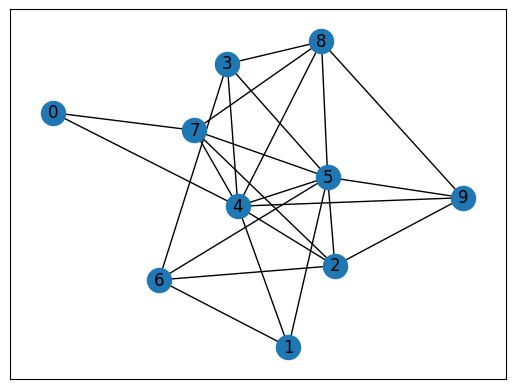

In [25]:
G = nx.read_gml("data/w_ba_n10_k4_0.gml")
nx.draw_networkx(G)
plt.show()

In [26]:
num_cons = 2
k = 6

Precomputed maximum value of the constrained cost function.

In [27]:
maxval = 5.965179720554735

In [ ]:
# Custom Mixer for Constrained MaxCut Problem
class ConstrainedMaxCut_Problem(problems.MaxKCutBinaryPowerOfTwo):
    def __init__(self, G, num_cons, k) -> None:
        self.num_cons = num_cons
        self.k = k
        super().__init__(G, k_cuts=2)

    def isFeasible(string, self):
        cons = 0
        w = 0
        for l in range(self.num_cons):
            c_sum = 0
            for m in range(self.k - 1):
                if w < len(string):
                    c_sum += int(string[w])
                    w += 1
            cons += np.abs(c_sum * (c_sum - 1))
        return math.isclose(cons, 0, abs_tol=1e-4)

In [ ]:
# Custom Mixer for Constrained MaxCut Problem
class ConstrainedMaxCut_Mixer(mixers.Mixer):
    def __init__(self, num_cons, k, depth):
        self.num_cons = num_cons
        self.k = k
        self.depth = depth
        ide = ["I"] * (k - 1)
        ide[0] = "Y"
        Zs = ["Z"] * (k - 1)
        Zs[0] = "Y"
        Zs = "".join(Zs)
        ide = "".join(ide)
        self.op = SparsePauliOp([ide, Zs], coeffs=[1.0, 1.0])

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        mixer_param = Parameter("x_beta")

        self.circuit = QuantumCircuit(q, name="Mixer")
        for r in range(self.depth):
            c = 0
            for i in range(self.num_cons):
                nsubqubits = int(self.N_qubits / self.num_cons)
                self.circuit.append(
                    PauliEvolutionGate(self.op, time=-1 / 2 * mixer_param / self.depth),
                    q[nsubqubits * i : nsubqubits * (i + 1)],
                )
                for j in range(k - 1):
                    if j != 0 and c < self.N_qubits:
                        self.circuit.append(
                            XXPlusYYGate(-2 * mixer_param / self.depth, np.pi),
                            [q[c - 1], q[c]],
                        )
                    c += 1

In [ ]:
# Custom Initial State for Constrained MaxCut Problem
class ConstrainedMaxCut_InitialState(initialstates.InitialState):
    def __init__(self, num_cons, k) -> None:
        self.num_cons = num_cons
        self.k = k

    def create_circuit(self):
        q = QuantumRegister(self.N_qubits)
        self.circuit = QuantumCircuit(q, name="initial_state")

        k = 0
        for i in range(self.num_cons):
            self.circuit.ry(2 * np.arccos(np.sqrt(1 / (self.k))), q[k])
            for j in range(self.k - 1):
                if not j == self.k - 2:
                    self.circuit.append(
                        XXPlusYYGate(
                            2 * np.arccos(np.sqrt(1 / (self.k - j - 1))), np.pi
                        ),
                        [q[k], q[k + 1]],
                    )
                k += 1

In [ ]:
# Initialize the QAOA instance with the custom problem, mixer, and initial state
qaoa = QAOA(
    problem=ConstrainedMaxCut_Problem(G, num_cons, k),
    mixer=ConstrainedMaxCut_Mixer(num_cons, k, 1),
    initialstate=ConstrainedMaxCut_InitialState(num_cons, k),
    optimizer=[COBYLA, {"maxiter": 100, "tol": 1e-6, "rhobeg": 1.3}],
    interpolate=False,
    shots=20000,
)

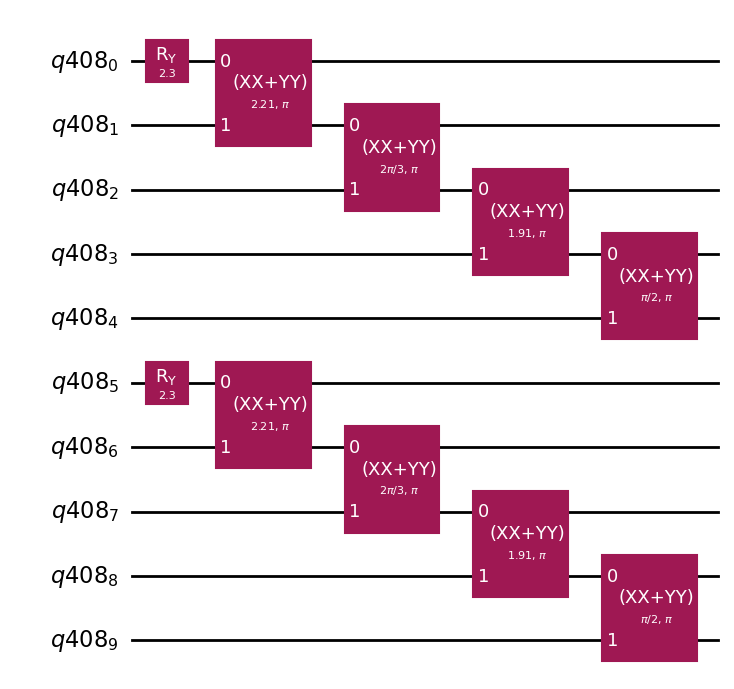

In [32]:
qaoa.createParameterizedCircuit(1)
qaoa.initialstate.circuit.draw("mpl")

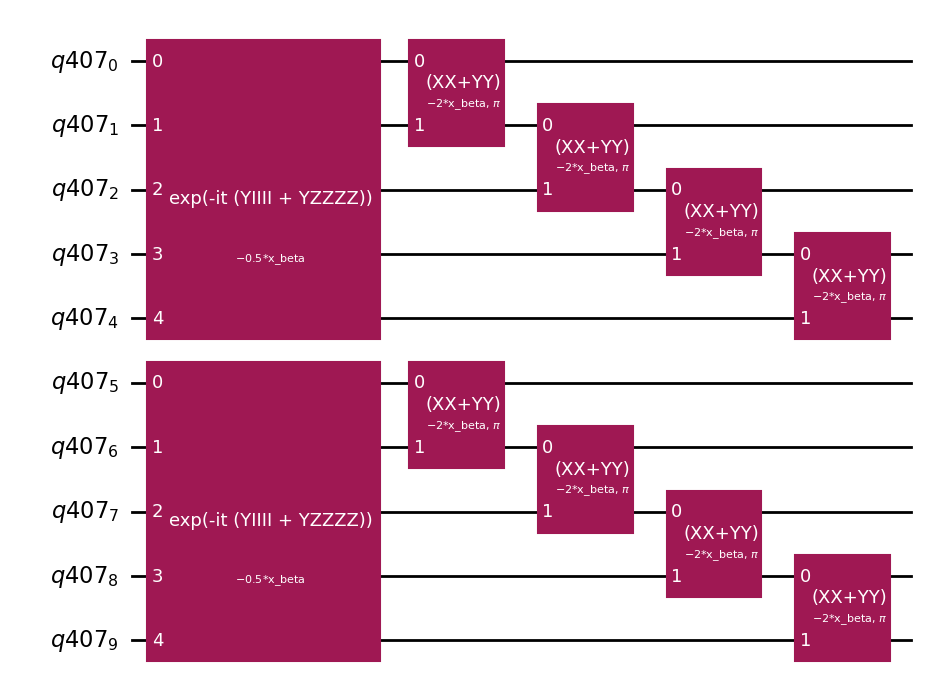

In [33]:
qaoa.mixer.circuit.draw("mpl")

2025-06-30 13:24:59 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2025-06-30 13:24:59 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2025-06-30 13:24:59 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2025-06-30 13:24:59 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2025-06-30 13:25:08 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2025-06-30 13:25:08 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


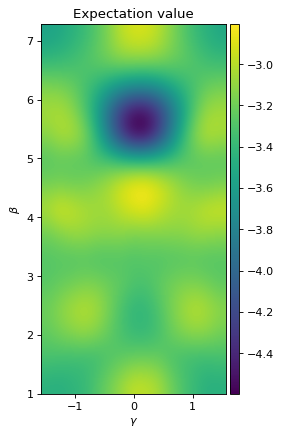

In [34]:
qaoa.sample_cost_landscape(
    angles={"gamma": [-np.pi / 2, np.pi / 2, 15], "beta": [1, 1 + 2 * np.pi, 15]}
)
plot_E(qaoa)

In [35]:
maxdepth = 25 # Maximum depth for the optimization
qaoa.optimize(depth=maxdepth) # Run the optimization process

2025-06-30 13:25:11 [info     ] cost(depth 1 = -4.83904406043867 file=qaoa.qaoa func=optimize
2025-06-30 13:25:16 [info     ] cost(depth 2 = -4.840031898334883 file=qaoa.qaoa func=optimize
2025-06-30 13:25:22 [info     ] cost(depth 3 = -4.846179612793151 file=qaoa.qaoa func=optimize
2025-06-30 13:25:30 [info     ] cost(depth 4 = -4.851932658931288 file=qaoa.qaoa func=optimize
2025-06-30 13:25:39 [info     ] cost(depth 5 = -4.851923457734958 file=qaoa.qaoa func=optimize
2025-06-30 13:25:49 [info     ] cost(depth 6 = -4.858648974598596 file=qaoa.qaoa func=optimize
2025-06-30 13:25:59 [info     ] cost(depth 7 = -4.857721729088869 file=qaoa.qaoa func=optimize
2025-06-30 13:26:10 [info     ] cost(depth 8 = -4.8606964000871695 file=qaoa.qaoa func=optimize
2025-06-30 13:26:24 [info     ] cost(depth 9 = -4.862842709375356 file=qaoa.qaoa func=optimize
2025-06-30 13:26:48 [info     ] cost(depth 10 = -4.86360616671753 file=qaoa.qaoa func=optimize
2025-06-30 13:27:00 [info     ] cost(depth 11 = -4

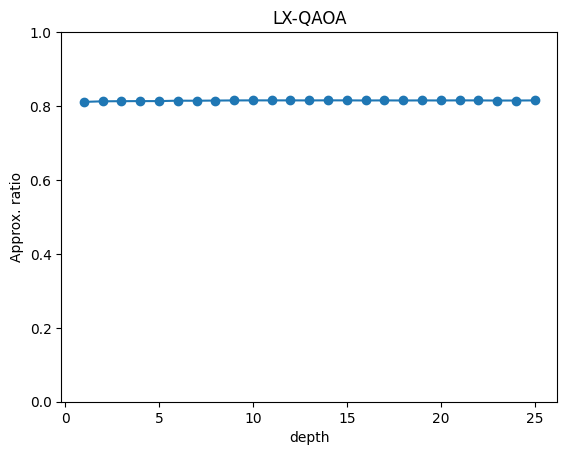

In [36]:
p = np.arange(1, len(np.array(qaoa.get_Exp())) + 1)
plt.plot(p, -np.array(qaoa.get_Exp()) / maxval, marker="o")
plt.xlabel("depth")
plt.ylabel("Approx. ratio")
plt.title("LX-QAOA")
plt.ylim([0, 1])
plt.show()